# Preamble

In [268]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pet_cli.graphical_analysis as pet_gph
import json
sns.set()
sns.set_style("ticks")
sns.set_context("paper")
plt.rcParams['font.family'] ='StixGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'

# Reading In Parameters

In [205]:
import os

def count_parameter_sets(model_directories: dict) -> dict:
    model_nums = {}
    for model, directory in model_directories.items():
        model_nums[model] = len([f for f in os.listdir(directory) if os.path.splitext(f)[1] == '.json'])
    return model_nums

In [209]:
DIR_PRE = "../../"
model_dirs = {"1tcm":f"{DIR_PRE}data/tcm_tacs/1tcm/",
              "serial_2tcm_k4zero":f"{DIR_PRE}data/tcm_tacs/serial_2tcm_k4zero/",
              "serial_2tcm":f"{DIR_PRE}data/tcm_tacs/serial_2tcm/"}

In [210]:
MODELS_NUMS = count_parameter_sets(model_dirs)
MODELS_NUMS

{'1tcm': 2, 'serial_2tcm_k4zero': 2, 'serial_2tcm': 3}

In [208]:
def safe_load_json(file_path):
    try:
        with open(file_path) as file:
            return json.load(file)
    except Exception as e:
        print(f"Couldn't read file {file_path}. Error: {e}")
        return None

In [215]:
DIR_PRE = "../../"
model_params = {
    model: {f'set-{i:02}': safe_load_json(f'{DIR_PRE}data/tcm_tacs/{model}/params_{model}_set-{i:02}.json') for i in
            range(num)} for model, num in MODELS_NUMS.items()}

In [222]:
from pprint import pprint
for model_name, params in model_params.items():
    pprint(params)
    print()

{'set-00': {'model': '1TCM', 'params': {'k1': 1.0, 'k2': 0.25}},
 'set-01': {'model': '1TCM', 'params': {'k1': 0.25, 'k2': 1.0}}}

{'set-00': {'model': 'Serial 2TCM (k4=0)',
            'params': {'k1': 0.5, 'k2': 0.5, 'k3': 0.01}},
 'set-01': {'model': 'Serial 2TCM (k4=0)',
            'params': {'k1': 0.5, 'k2': 0.5, 'k3': 0.25}}}

{'set-00': {'model': 'Serial 2TCM',
            'params': {'k1': 0.5, 'k2': 0.85, 'k3': 0.01, 'k4': 0.01}},
 'set-01': {'model': 'Serial 2TCM',
            'params': {'k1': 0.5, 'k2': 0.85, 'k3': 0.25, 'k4': 0.01}},
 'set-02': {'model': 'Serial 2TCM',
            'params': {'k1': 0.5, 'k2': 0.85, 'k3': 0.25, 'k4': 0.15}}}



## Generating Theoretical Values From Parameters

### Patlak Plots

In [232]:
import numpy as np

def tcm_1tcm_patlak_slope_and_intercept(model_params: dict) -> dict:
    k1, k2 = model_params['k1'], model_params['k2']
    if k2 == 0.0:
        slope = k1
    else:
        slope = 0.0
    intercept = np.nan
    patlak_slope_intercept = {'slope': slope, 'intercept': intercept}
    return patlak_slope_intercept


def tcm_serial_2tcm_k4zero_patlak_slope_and_intercept(model_params: dict) -> dict:
    k1 = model_params['k1']
    k2 = model_params['k2']
    k3 = model_params['k3']
    slope = (k1 * k3) / (k2 + k3)
    intercept = np.nan
    patlak_slope_intercept = {'slope': slope, 'intercept': intercept}
    return patlak_slope_intercept


def tcm_serial_2tcm_patlak_slope_and_intercept(model_params: dict) -> dict:
    slope = 0.0
    intercept = np.nan
    patlak_slope_intercept = {'slope': slope, 'intercept': intercept}
    return patlak_slope_intercept


def tcm_calculate_patlak_from_model(model_desc: dict) -> dict:
    model = model_desc['model']
    params = model_desc['params']
    if model == '1TCM':
        return tcm_1tcm_patlak_slope_and_intercept(params)
    elif model == 'Serial 2TCM (k4=0)':
        return tcm_serial_2tcm_k4zero_patlak_slope_and_intercept(params)
    elif model == 'Serial 2TCM':
        return tcm_serial_2tcm_patlak_slope_and_intercept(params)
    else:
        return {'slope': np.nan, 'intercept': np.nan}


### Logan Plots

In [233]:
def tcm_1tcm_logan_slope_and_intercept(model_params: dict) -> dict:
    k1, k2 = model_params['k1'], model_params['k2']
    slope = k1 / k2
    intercept = -1.0 / k2
    patlak_slope_intercept = {'slope': slope, 'intercept': intercept, 'ratio': -slope / intercept}
    return patlak_slope_intercept


def tcm_serial_2tcm_logan_slope_and_intercept(model_params: dict) -> dict:
    k1 = model_params['k1']
    k2 = model_params['k2']
    k3 = model_params['k3']
    k4 = model_params['k4']
    slope = (k1 / k2) / (1.0 + k3 / k4)
    intercept = -((1.0 / k2) * (1.0 + k3 / k4) + 1.0 / (k4 + (1.0 + k4 / k3)))
    patlak_slope_intercept = {'slope': slope, 'intercept': intercept, 'ratio': -slope / intercept}
    return patlak_slope_intercept


def tcm_calculate_logan_from_model(model_desc: dict) -> dict:
    model = model_desc['model']
    params = model_desc['params']
    if model == '1TCM':
        return tcm_1tcm_logan_slope_and_intercept(params)
    elif model == 'Serial 2TCM (k4=0)':
        return {'slope': np.nan, 'intercept': np.nan}
    elif model == 'Serial 2TCM':
        return tcm_serial_2tcm_logan_slope_and_intercept(params)
    else:
        return {'slope': np.nan, 'intercept': np.nan, 'ratio': np.nan}


# Comparing Calculated Values With Theoretical Values

### Reading In The Plasma TAC

In [234]:
pTAC = np.array(np.loadtxt('../../data/tcm_tacs/fdg_plasma_clamp_evenly_resampled.txt').T, order='C', dtype=float)

## Noise Free

### Reading In TACs

In [223]:
def safe_load_tac(filename):
    try:
        return np.array(np.loadtxt(filename).T, dtype=float, order='C')
    except Exception as e:
        print(f"Couldn't read file {filename}. Error: {e}")
        return None

In [254]:
all_tacs = {}
all_tacs['noise-free'] = {a_model: {f'set-{i:02}': safe_load_tac(
    f'{DIR_PRE}data/tcm_tacs/{a_model}/noise_free/tac_{("_".join(a_model.split("_")[1:]) if "serial_2tcm" in a_model else a_model)}_set-{i:02}.txt')
    for i in range(num)} for a_model, num in MODELS_NUMS.items()}
all_tacs['gaussian-noise'] = {a_model: {f'set-{i:02}': safe_load_tac(
    f'{DIR_PRE}data/tcm_tacs/{a_model}/gaussian_noise/tac_{("_".join(a_model.split("_")[1:]) if "serial_2tcm" in a_model else a_model)}_set-{i:02}.txt')
    for i in range(num)} for a_model, num in MODELS_NUMS.items()}

### Patlak Analysis

#### Code For Plots

In [251]:
def gen_patlak_plot(pTAC, tTAC):
    x = pet_gph.cumulative_trapezoidal_integral(xdata=pTAC[0], ydata=pTAC[1]) / pTAC[1]
    y = tTAC[1]/pTAC[1]
    return np.array([x, y])
    

In [252]:
patlak_xLab = r"$\frac{\int_{0}^{t}C_\mathrm{P}(s)\mathrm{d}s}{C_\mathrm{P}(t)}$"
patlak_yLab = r"$\frac{R(t)}{C_\mathrm{P}(t)}$"

In [253]:
def params_dict_to_label(params):
    tmp = []
    for p, val in params.items():
        tmp.append(f"$k_{{{p[1:]}}}={float(val):<.2f}$")
    return "; ".join(tmp)
params_dict_to_label(_params["params"])

'$k_{1}=0.50$; $k_{2}=0.85$; $k_{3}=0.25$; $k_{4}=0.15$'

#### Plotting

/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_30770/581802919.py:2: RuntimeWarning: invalid value encountered in divide
  x = pet_gph.cumulative_trapezoidal_integral(xdata=pTAC[0], ydata=pTAC[1]) / pTAC[1]
/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_30770/581802919.py:3: RuntimeWarning: invalid value encountered in divide
  y = tTAC[1]/pTAC[1]


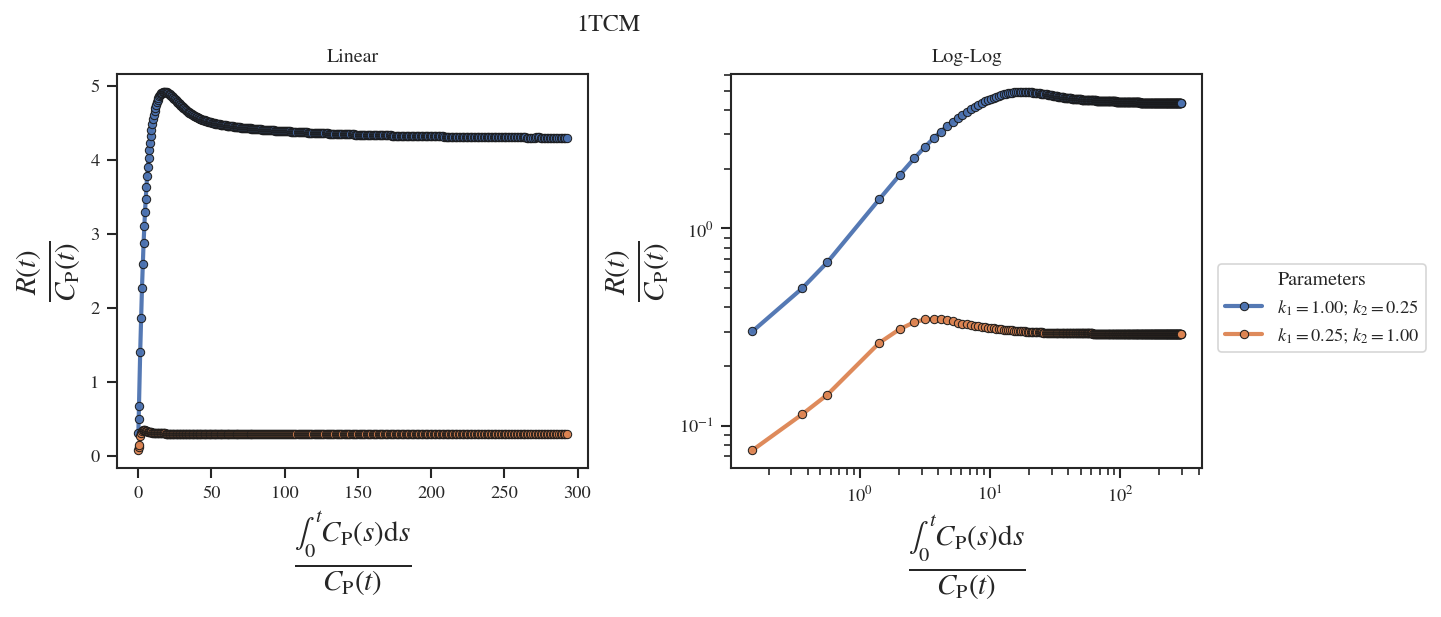

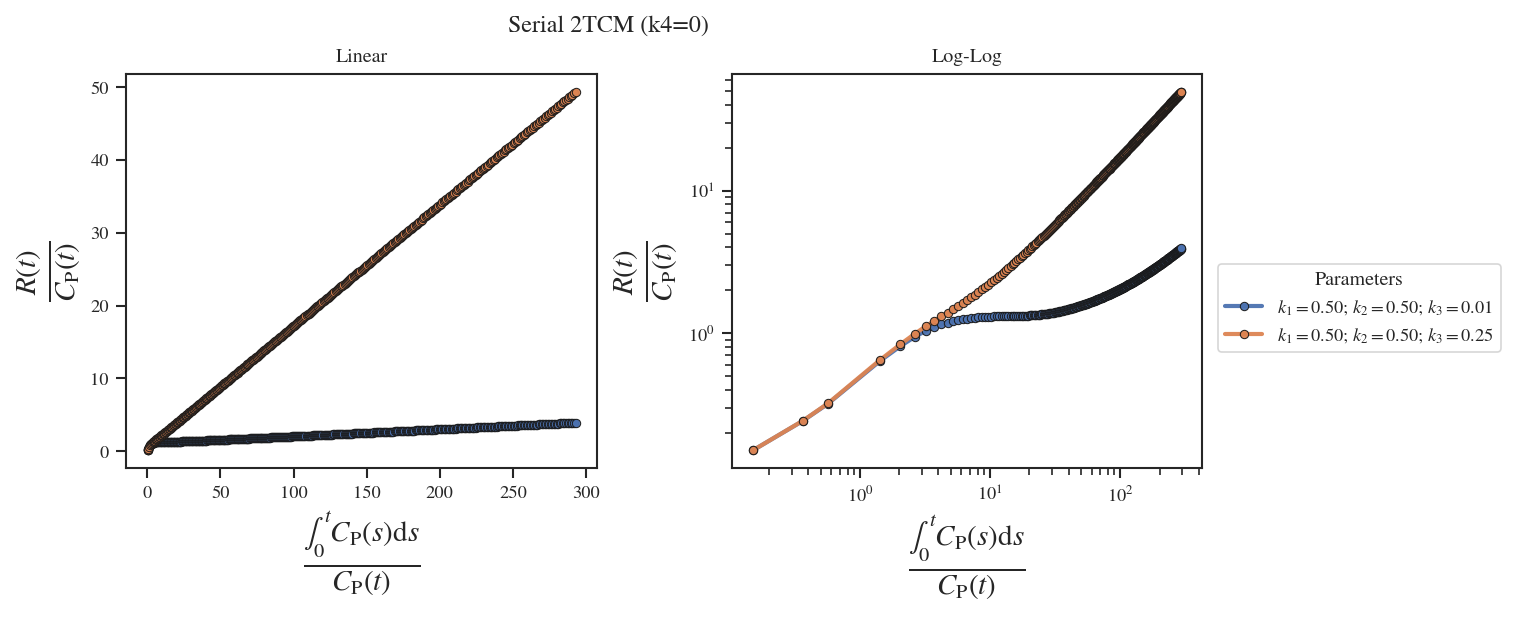

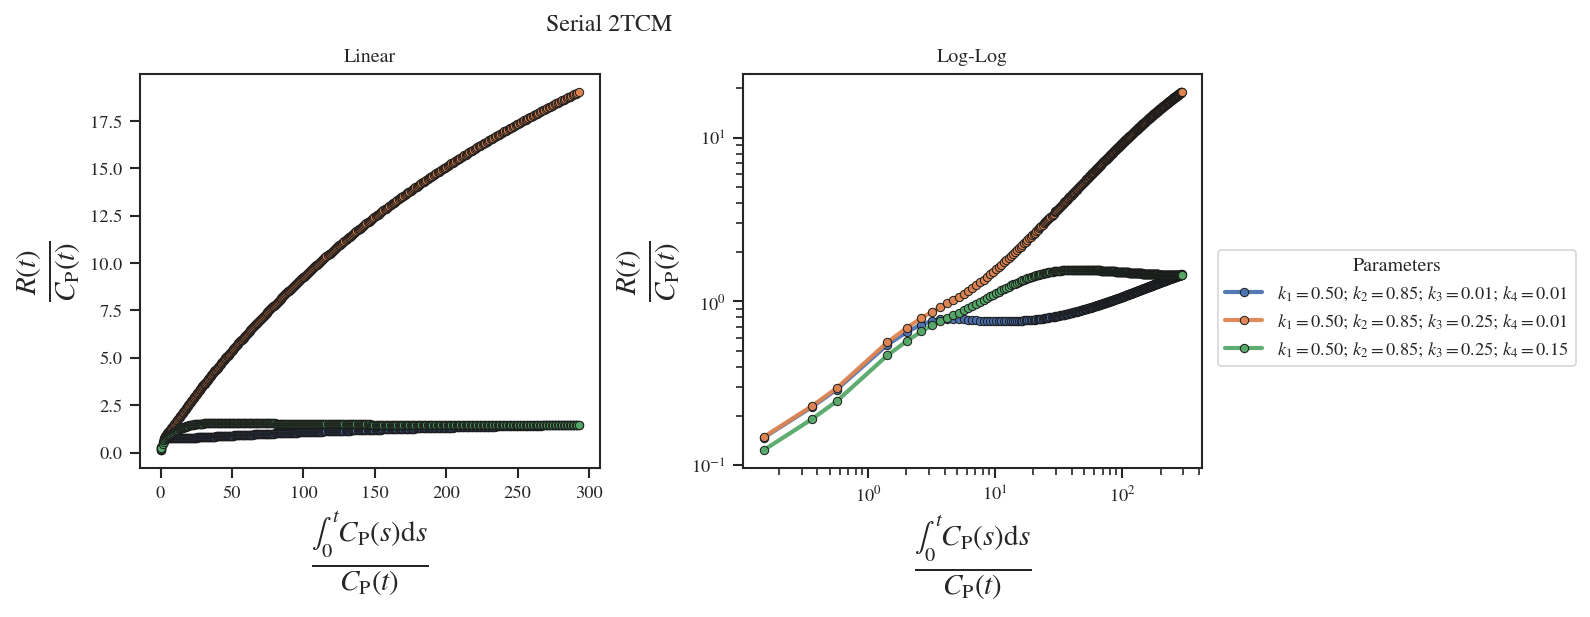

In [297]:
for a_model, num in MODELS_NUMS.items():
    myFig, myAx = plt.subplots(1, 2, constrained_layout=True, figsize=[8, 4], dpi=150)
    for i in range(num):
        _params = model_params[a_model][f"set-{i:02}"]
        _tTAC = all_tacs['noise-free'][a_model][f"set-{i:02}"]
        patlak_vars = gen_patlak_plot(pTAC, _tTAC)
        
        myAx[0].plot(*patlak_vars, '.-', alpha=0.95, lw=2, label=params_dict_to_label(_params['params']), color=f"C{i}",
                     ms=8, mec='k', mew=0.5)
        myAx[1].plot(*patlak_vars, '.-', alpha=0.95, lw=2, color=f"C{i}", ms=8, mec='k', mew=0.5)
    
    #     for i in range(num):
    #         _params = model_params[a_model][f"set-{i:02}"]
    #         _tTAC = all_tacs['gaussian-noise'][a_model][f"set-{i:02}"]
    #         patlak_vars = gen_patlak_plot(pTAC, _tTAC)
    #         for anAx in myAx.flatten():
    #             anAx.plot(*patlak_vars, '.', alpha=0.7, lw=2, ms=8, color=f'C{i}', zorder=-1, mec='white')
    #             anAx.axvline(patlak_vars[0][np.argwhere(pTAC[0] >= 30.)[0, 0]], color=f'k', zorder=-1, alpha=0.6, ls='--')
    myAx[0].set(title=f"Linear")
    myAx[1].set(title=f"Log-Log", xscale='log', yscale='log')
    myAx[0].set_xlabel(patlak_xLab, fontsize=20)
    myAx[0].set_ylabel(patlak_yLab, fontsize=20)
    myAx[1].set_xlabel(patlak_xLab, fontsize=20)
    myAx[1].set_ylabel(patlak_yLab, fontsize=20)
    myFig.suptitle(f"{_params['model']}")
    myFig.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', title='Parameters')
    plt.show()

#### Comparing Values

In [241]:
for a_model, num in MODELS_NUMS.items():
    print(a_model)
    for i in range(num):
        _params = model_params[a_model][f"set-{i:02}"]
        _tTAC   = all_tacs[a_model][f"set-{i:02}"][1]
        true_vals = tcm_calculate_patlak_from_model(_params)
        calc_vals = pet_gph.patlak_analysis(input_tac_values=pTAC[1],
                                           region_tac_values=_tTAC,
                                           tac_times_in_minutes=pTAC[0],
                                           t_thresh_in_minutes=30.0)
        print(f"{true_vals['slope']:.5f}", f"{calc_vals[0]:.5f}")
    print()

1tcm
0.00000 -0.00070
0.00000 -0.00001

serial_2tcm_k4zero
0.00980 0.00973
0.16667 0.16665

serial_2tcm
0.00000 0.00232
0.00000 0.05596
0.00000 -0.00049



### Logan Analysis

#### Plotting Code

In [242]:
def gen_logan_plot(pTAC, tTAC):
    x = pet_gph.cumulative_trapezoidal_integral(xdata=pTAC[0], ydata=pTAC[1]) / tTAC[1]
    y = pet_gph.cumulative_trapezoidal_integral(xdata=tTAC[0], ydata=tTAC[1]) / tTAC[1]
    return np.array([x, y])

def gen_alt_logan_plot(pTAC, tTAC):
    x = pet_gph.cumulative_trapezoidal_integral(xdata=pTAC[0], ydata=pTAC[1]) / pTAC[1]
    y = pet_gph.cumulative_trapezoidal_integral(xdata=tTAC[0], ydata=tTAC[1]) / pTAC[1]
    return np.array([x, y])
    

In [243]:
logan_xLab = r"$\frac{\int_{0}^{t}C_\mathrm{P}(s)\mathrm{d}s}{R(t)}$"
logan_yLab = r"$\frac{\int_{0}^{t}R(s)\mathrm{d}s}{R(t)}$"

#### Plotting

/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_30770/3548088199.py:2: RuntimeWarning: invalid value encountered in divide
  x = pet_gph.cumulative_trapezoidal_integral(xdata=pTAC[0], ydata=pTAC[1]) / tTAC[1]
/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_30770/3548088199.py:3: RuntimeWarning: invalid value encountered in divide
  y = pet_gph.cumulative_trapezoidal_integral(xdata=tTAC[0], ydata=tTAC[1]) / tTAC[1]


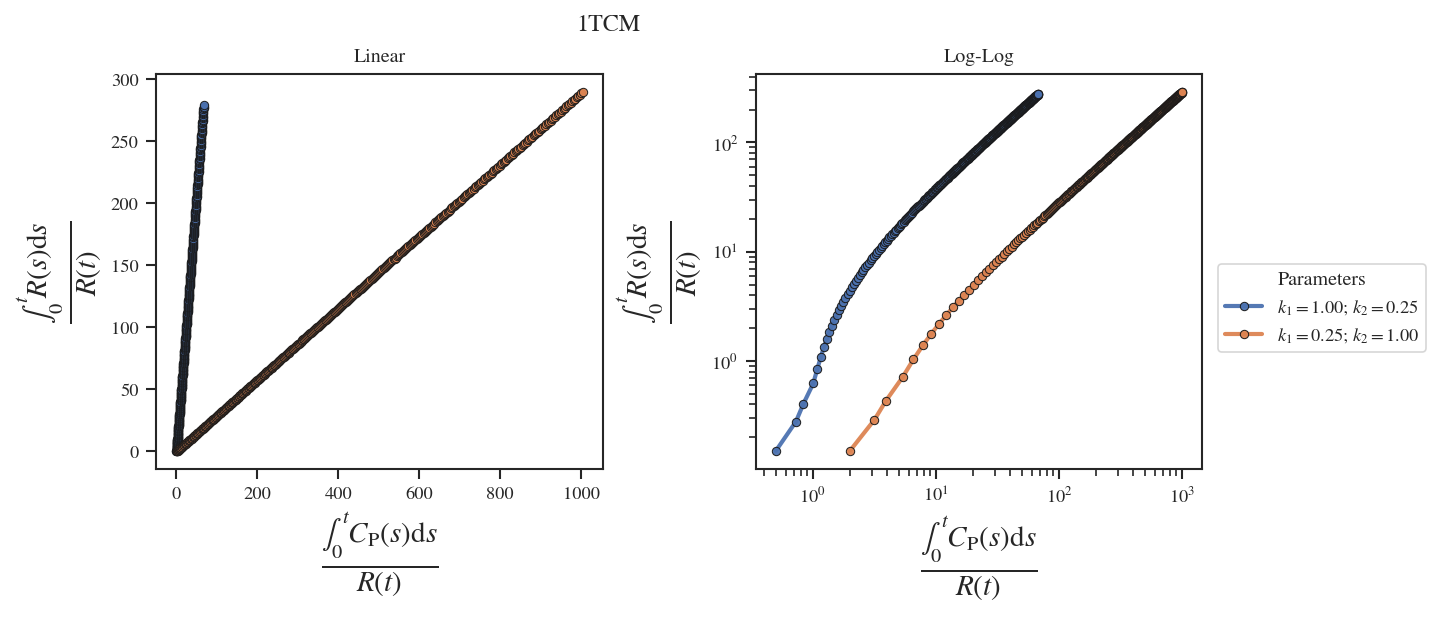

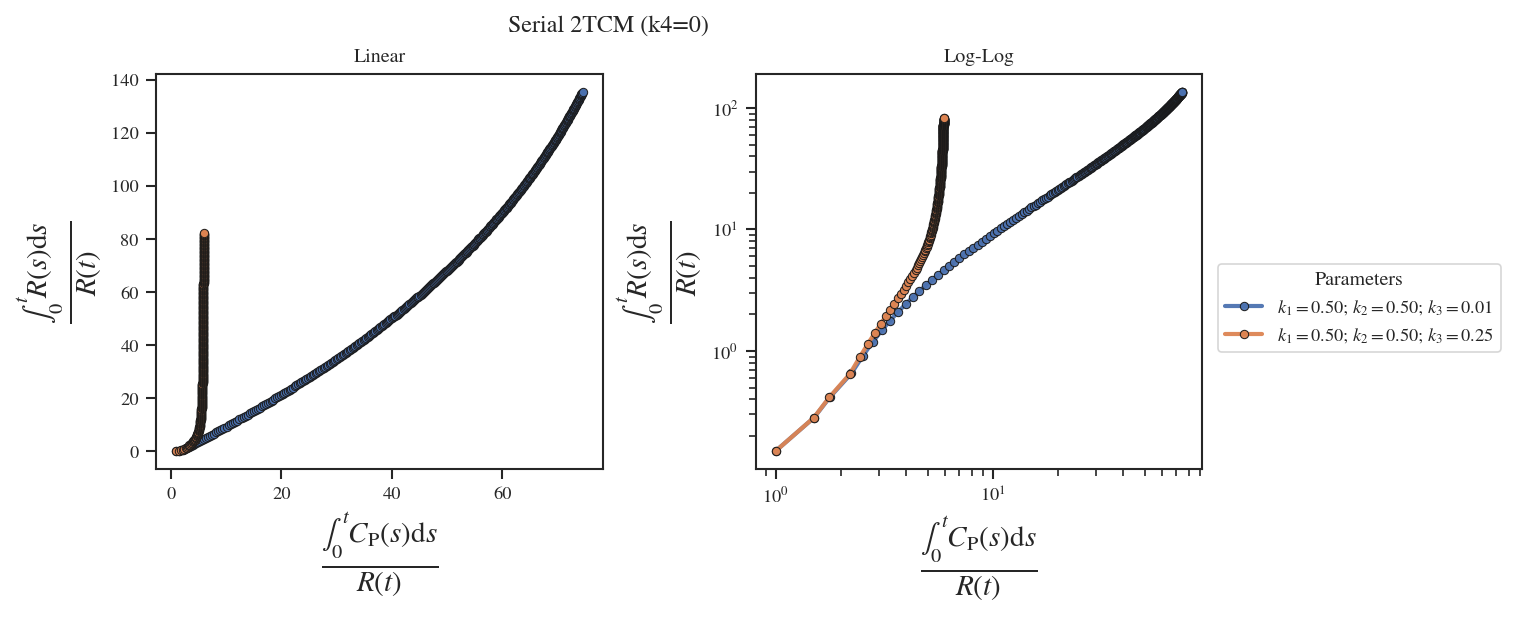

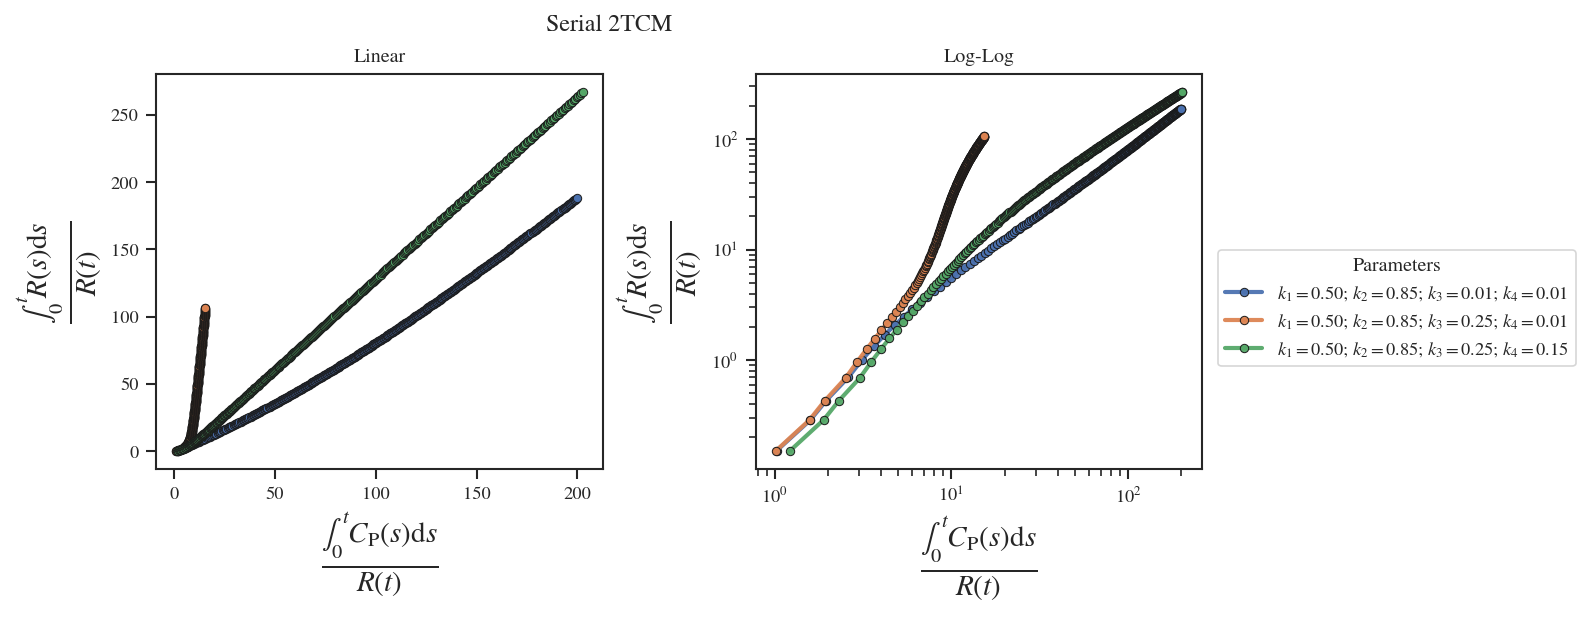

In [296]:
for a_model, num in MODELS_NUMS.items():
    myFig, myAx = plt.subplots(1, 2, constrained_layout=True, figsize=[8, 4], dpi=150)
    for i in range(num):
        _params = model_params[a_model][f"set-{i:02}"]
        _tTAC = all_tacs['noise-free'][a_model][f"set-{i:02}"]
        logan_vars = gen_logan_plot(pTAC, _tTAC)
        
        myAx[0].plot(*logan_vars, '.-', alpha=0.95, lw=2, 
                     label=params_dict_to_label(_params['params']), color=f"C{i}", ms=8, mec='k', mew=0.5)
        myAx[1].plot(*logan_vars, '.-', alpha=0.95, lw=2, color=f"C{i}", ms=8, mec='k', mew=0.5)
    
#     for i in range(num):
#         _params = model_params[a_model][f"set-{i:02}"]
#         _tTAC = all_tacs['gaussian-noise'][a_model][f"set-{i:02}"]
#         logan_vars = gen_logan_plot(pTAC, _tTAC)
#         for anAx in myAx.flatten():
#             anAx.plot(*logan_vars, '.', alpha=0.7, lw=2, ms=8, color=f'C{i}', zorder=-1, mec='white')
#             anAx.axvline(logan_vars[0][np.argwhere(pTAC[0] >= 30.)[0, 0]], color=f'k', zorder=-1, alpha=0.6, ls='--')
    myAx[0].set(title=f"Linear")
    myAx[1].set(title=f"Log-Log", xscale='log', yscale='log')
    myAx[0].set_xlabel(logan_xLab, fontsize=20)
    myAx[0].set_ylabel(logan_yLab, fontsize=20)
    myAx[1].set_xlabel(logan_xLab, fontsize=20)
    myAx[1].set_ylabel(logan_yLab, fontsize=20)
    myFig.suptitle(f"{_params['model']}")
    myFig.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', title='Parameters')
    plt.show()

/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_30770/3548088199.py:2: RuntimeWarning: invalid value encountered in divide
  x = pet_gph.cumulative_trapezoidal_integral(xdata=pTAC[0], ydata=pTAC[1]) / tTAC[1]
/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_30770/3548088199.py:3: RuntimeWarning: invalid value encountered in divide
  y = pet_gph.cumulative_trapezoidal_integral(xdata=tTAC[0], ydata=tTAC[1]) / tTAC[1]


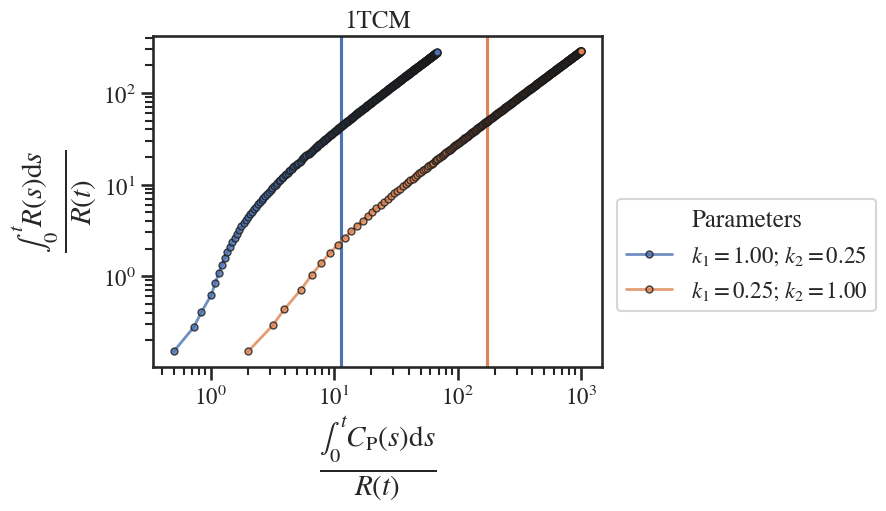

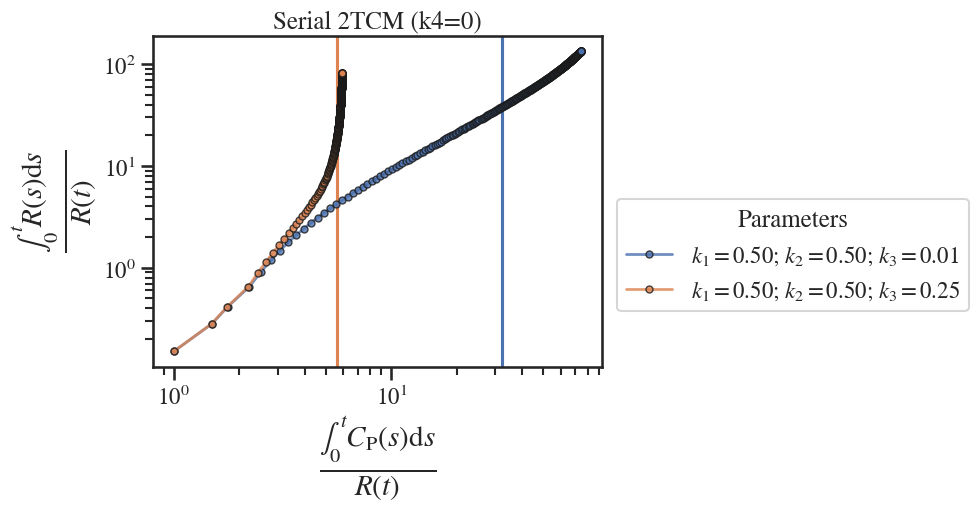

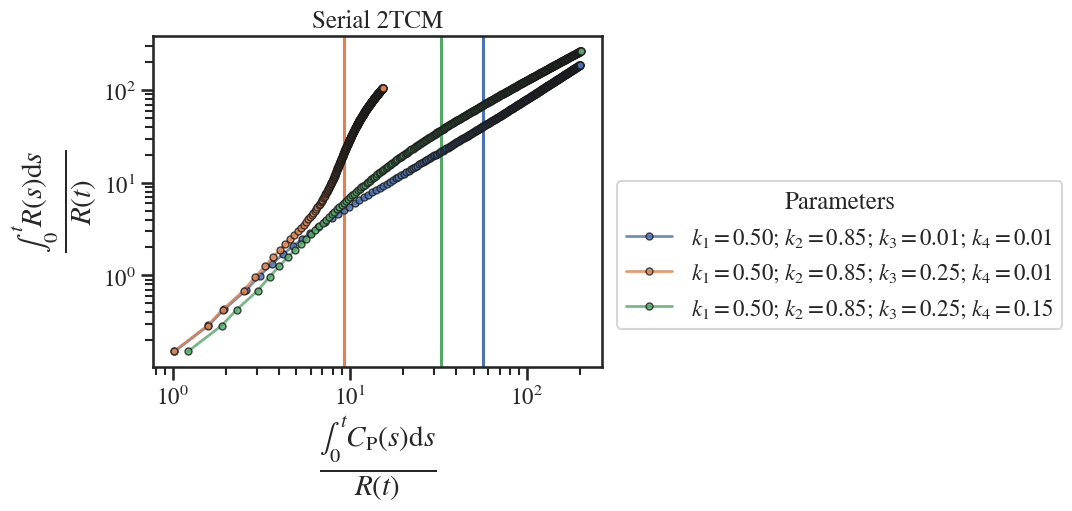

In [244]:
for a_model, num in MODELS_NUMS.items():
    myFig, myAx = plt.subplots(1,1, constrained_layout=True, figsize=[6,5])
    for i in range(num):
        _params = model_params[a_model][f"set-{i:02}"]
        _tTAC   = all_tacs[a_model][f"set-{i:02}"]
        patlak_vars = gen_logan_plot(pTAC, _tTAC)
        
        myAx.plot(*patlak_vars, '.-', alpha=0.8, lw=2, mec='k', ms=10, label=params_dict_to_label(_params['params']))
        myAx.axvline(patlak_vars[0][np.argwhere(pTAC[0]>=30.)[0,0]], color=f'C{i}', zorder=-1)
    myAx.set(title=f"{_params['model']}", xscale='log' , yscale='log')
    myAx.set_xlabel(logan_xLab, fontsize=30)
    myAx.set_ylabel(logan_yLab, fontsize=30)
    myFig.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', title='Parameters')
    plt.show()

#### Comparing Values

In [249]:
for a_model, num in MODELS_NUMS.items():
    print(a_model)
    for i in range(num):
        _params = model_params[a_model][f"set-{i:02}"]
        _tTAC   = all_tacs[a_model][f"set-{i:02}"][1]
        true_vals = tcm_calculate_logan_from_model(_params)
        calc_vals = pet_gph.logan_analysis(input_tac_values=pTAC[1],
                                           region_tac_values=_tTAC,
                                           tac_times_in_minutes=pTAC[0],
                                           t_thresh_in_minutes=100.0)
        
        print(f"({true_vals['slope']:<8.5f}; {calc_vals[0]:<8.5f}); \
({true_vals['intercept']:<8.5f}; {calc_vals[1]:<8.5f}); \
({_params['params']['k1']:<8.5f}; {-calc_vals[0]/calc_vals[1]:<8.5f})")
    print()

1tcm
(4.00000 ; 4.15251 ); (-4.00000; -3.85801); (1.00000 ; 1.07634 )
(0.25000 ; 0.28954 ); (-1.00000; -0.85838); (0.25000 ; 0.33730 )

serial_2tcm_k4zero
(nan     ; 3.61729 ); (nan     ; -134.65514); (0.50000 ; 0.02686 )
(nan     ; 775.84796); (nan     ; -4523.57762); (0.50000 ; 0.17151 )

serial_2tcm
(0.29412 ; 1.12794 ); (-2.85045; -37.49602); (0.50000 ; 0.03008 )
(0.02262 ; 14.84389); (-31.54062; -121.97521); (0.50000 ; 0.12170 )
(0.22059 ; 1.35208 ); (-3.70868; -7.11385); (0.50000 ; 0.19006 )



## With Gaussian Noise

### Reading In TACs

In [190]:
all_tacs = {}
for a_model, num in MODELS_NUMS.items():
    all_tacs[a_model] = {}
    if 'serial_2tcm' in a_model:
        _model = "_".join(a_model.split("_")[1:])
    else:
        _model = a_model[:]
    for i in range(num):
        all_tacs[a_model][f'set-{i:02}'] = {}
        filename=f'../../data/tcm_tacs/{a_model}/gaussian_noise/tac_{_model}_set-{i:02}.txt'
        all_tacs[a_model][f'set-{i:02}'] = np.array(np.loadtxt(filename).T, dtype=float, order='C')

### Patlak Analysis

#### Plots



/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_30770/581802919.py:2: RuntimeWarning: invalid value encountered in divide
  x = pet_gph.cumulative_trapezoidal_integral(xdata=pTAC[0], ydata=pTAC[1]) / pTAC[1]
/var/folders/mk/pnrjjqkx6wq8zxfjrfqfst4h0000gp/T/ipykernel_30770/581802919.py:3: RuntimeWarning: divide by zero encountered in divide
  y = tTAC[1]/pTAC[1]


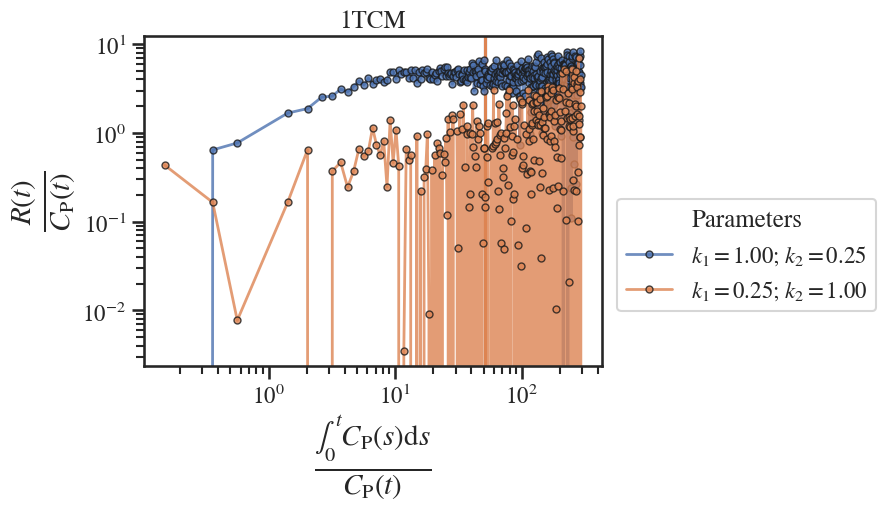

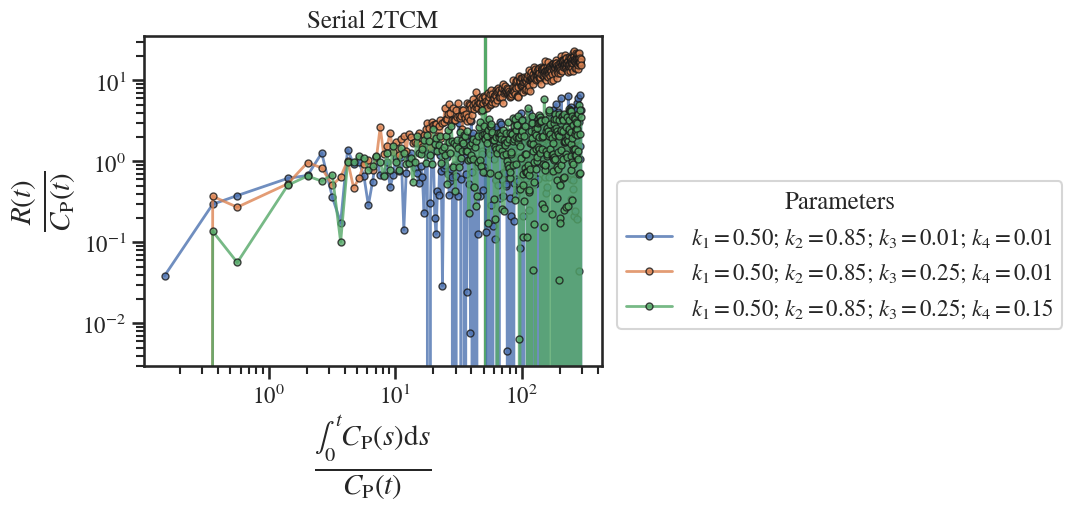

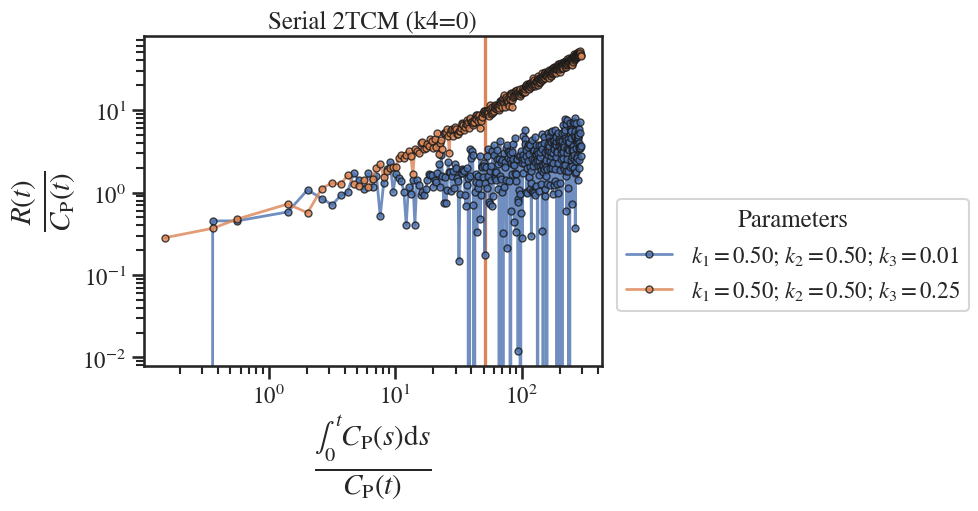

In [191]:
for a_model, num in MODELS_NUMS.items():
    myFig, myAx = plt.subplots(1,1, constrained_layout=True, figsize=[6,5])
    for i in range(num):
        _params = model_params[a_model][f"set-{i:02}"]
        _tTAC   = all_tacs[a_model][f"set-{i:02}"]
        patlak_vars = gen_patlak_plot(pTAC, _tTAC)
        
        myAx.plot(*patlak_vars, '.-', alpha=0.8, lw=2, mec='k', ms=10, label=params_dict_to_label(_params['params']))
        myAx.axvline(patlak_vars[0][np.argwhere(pTAC[0]>=30.)[0,0]], color=f'C{i}', zorder=-1)
    myAx.set(title=f"{_params['model']}", xscale='log', yscale='log')
    myAx.set_xlabel(patlak_xLab, fontsize=30)
    myAx.set_ylabel(patlak_yLab, fontsize=30)
    myFig.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', title='Parameters')
    plt.show()

#### Comparing Values

In [196]:
for a_model, num in MODELS_NUMS.items():
    print(a_model)
    for i in range(num):
        _params = model_params[a_model][f"set-{i:02}"]
        _tTAC   = all_tacs[a_model][f"set-{i:02}"]
        true_vals = tcm_calculate_patlak_from_model(_params)
        calc_vals = pet_gph.patlak_analysis(input_tac_values=pTAC[1],
                                           region_tac_values=_tTAC[1],
                                           tac_times_in_minutes=pTAC[0],
                                           t_thresh_in_minutes=30.0)
        print(f"{true_vals['slope']:.5f}", f"{calc_vals[0]:.5f}")
    print()

1tcm
0.00000 -0.00083
0.00000 0.00150

serial_2tcm
0.00000 0.00163
0.00000 0.05436
0.00000 -0.00345

serial_2tcm_k4zero
0.00980 0.00945
0.16667 0.16389



### Logan Analysis

#### Plots

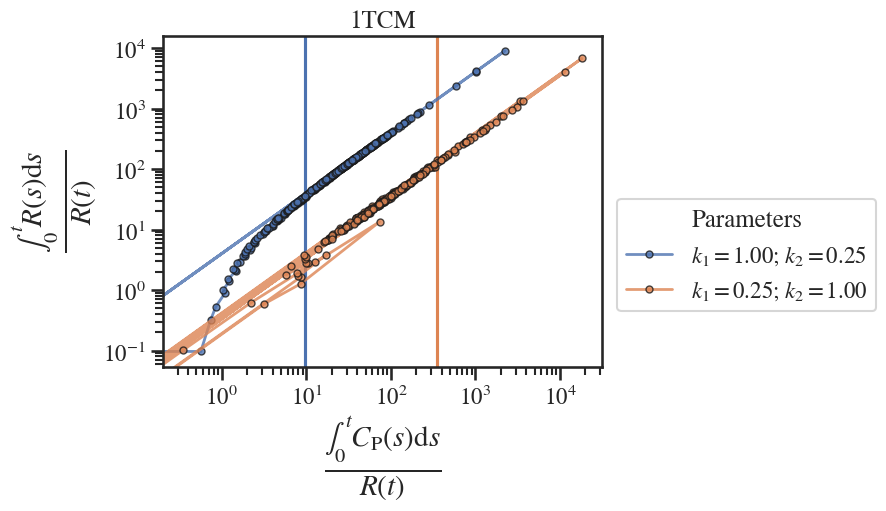

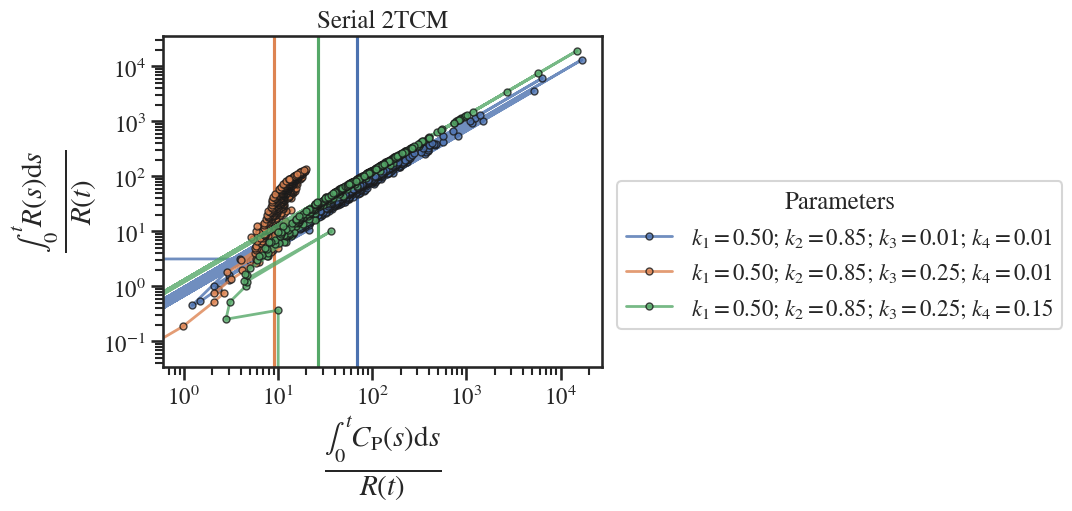

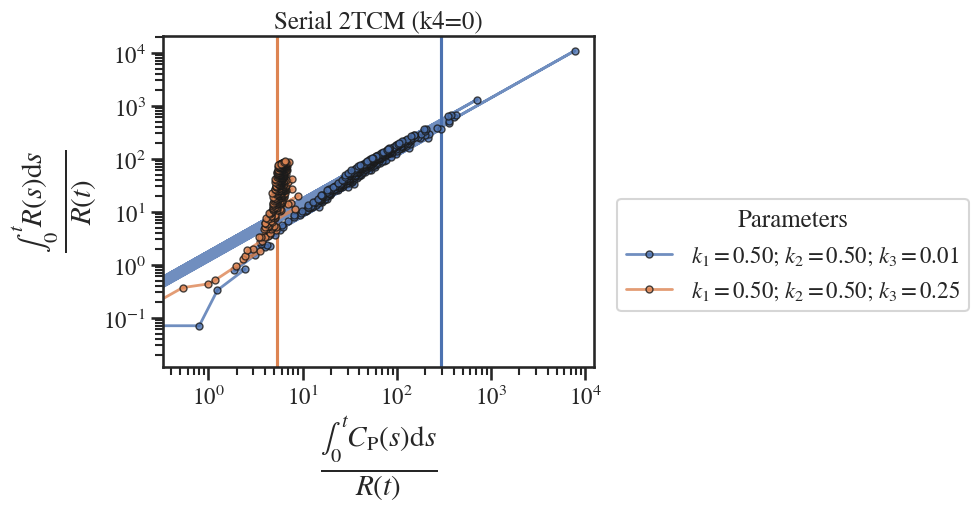

In [189]:
for a_model, num in MODELS_NUMS.items():
    myFig, myAx = plt.subplots(1,1, constrained_layout=True, figsize=[6,5])
    for i in range(num):
        _params = model_params[a_model][f"set-{i:02}"]
        _tTAC   = all_tacs[a_model][f"set-{i:02}"]
        patlak_vars = gen_logan_plot(pTAC, _tTAC)
        
        myAx.plot(*patlak_vars, '.-', alpha=0.8, lw=2, mec='k', ms=10, label=params_dict_to_label(_params['params']))
        myAx.axvline(patlak_vars[0][np.argwhere(pTAC[0]>=30.)[0,0]], color=f'C{i}', zorder=-1)
    myAx.set(title=f"{_params['model']}", xscale='log', yscale='log')
    myAx.set_xlabel(logan_xLab, fontsize=30)
    myAx.set_ylabel(logan_yLab, fontsize=30)
    myFig.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', title='Parameters')
    plt.show()

#### Comparing Values

In [172]:
for a_model, num in MODELS_NUMS.items():
    print(a_model)
    for i in range(num):
        _params = model_params[a_model][f"set-{i:02}"]
        _tTAC   = all_tacs[a_model][f"set-{i:02}"][1]
        true_vals = tcm_calculate_logan_from_model(_params)
        calc_vals = pet_gph.logan_analysis(input_tac_values=pTAC[1],
                                           region_tac_values=_tTAC,
                                           tac_times_in_minutes=pTAC[0],
                                           t_thresh_in_minutes=30.0)
        
        print(f"({true_vals['slope']:<8.5f}; {calc_vals[0]:<8.5f}); ({true_vals['intercept']:<8.5f}; {calc_vals[1]:<8.5f}); ({_params['params']['k1']:<8.5f}; {-calc_vals[0]/calc_vals[1]:<8.5f})")
    print()

1tcm
(4.00000 ; 4.03688 ); (-4.00000; -1.18296); (1.00000 ; 3.41251 )
(0.25000 ; 0.36184 ); (-1.00000; 1.04883 ); (0.25000 ; -0.34499)

serial_2tcm
(0.29412 ; 0.81940 ); (-2.85045; -2.11087); (0.50000 ; 0.38818 )
(0.02262 ; 9.88850 ); (-31.54062; -60.78291); (0.50000 ; 0.16269 )
(0.22059 ; 1.28152 ); (-3.70868; 0.06952 ); (0.50000 ; -18.43252)

serial_2tcm_k4zero
(nan     ; 1.41434 ); (nan     ; 10.05286); (0.50000 ; -0.14069)
(nan     ; 16.98707); (nan     ; -49.29160); (0.50000 ; 0.34462 )

